In [1]:
import os
import requests
import zipfile

# Create COCO directory
os.makedirs("coco", exist_ok=True)

# URLs for COCO dataset
annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
images_url = "http://images.cocodataset.org/zips/train2017.zip"

# File paths
annotations_zip = "coco/annotations_trainval2017.zip"
images_zip = "coco/train2017.zip"

# Function to download files
def download_file(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {save_path}...")
        response = requests.get(url, stream=True)
        with open(save_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print(f"Download complete: {save_path}")
    else:
        print(f"File already exists: {save_path}")

# Function to extract files
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted: {zip_path}")

# Download & extract annotations
download_file(annotations_url, annotations_zip)
extract_zip(annotations_zip, "coco")

# Download & extract images
download_file(images_url, images_zip)
extract_zip(images_zip, "coco")

File already exists: coco/annotations_trainval2017.zip
Extracted: coco/annotations_trainval2017.zip
File already exists: coco/train2017.zip
Extracted: coco/train2017.zip


In [2]:
from pycocotools.coco import COCO

# Load COCO dataset
coco = COCO("coco/annotations/instances_train2017.json")

# Get category names
categories = coco.loadCats(coco.getCatIds())
category_names = [cat["name"] for cat in categories]
print("COCO Categories:", category_names)

loading annotations into memory...
Done (t=14.63s)
creating index...
index created!
COCO Categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


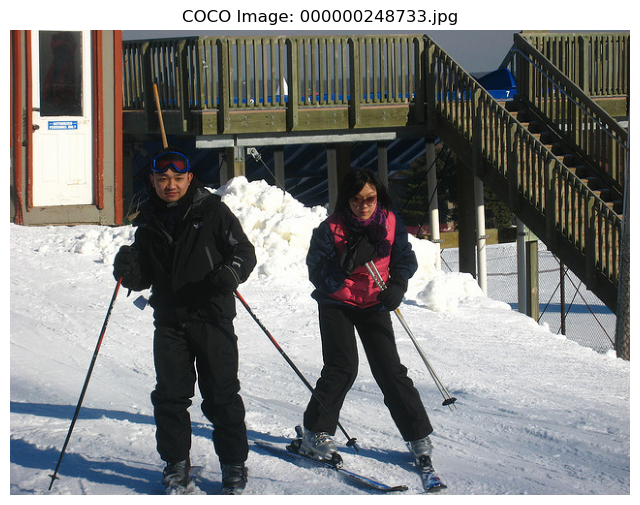

In [3]:
import cv2
import matplotlib.pyplot as plt
import random

# Get image IDs for a category (e.g., "person")
cat_ids = coco.getCatIds(catNms=["person"])
img_ids = coco.getImgIds(catIds=cat_ids)
img_info = coco.loadImgs(random.choice(img_ids))[0]

# Load image
img_path = os.path.join("coco/train2017", img_info["file_name"])

# Verify if image exists before loading
if not os.path.exists(img_path):
    print(f"Image file not found: {img_path}")
else:
    # Load and display image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"COCO Image: {img_info['file_name']}")
    plt.show()

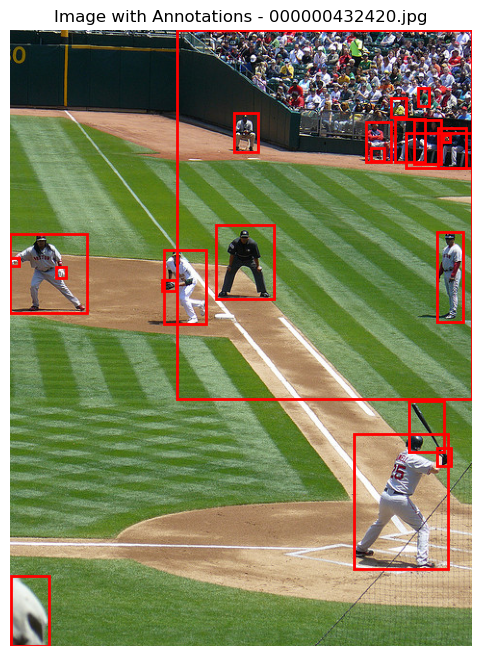

In [9]:
def show_image_with_annotations(image_id):
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join("coco/train2017", img_info["file_name"])

    if not os.path.exists(img_path):
        print(f"Image file not found: {img_path}")
        return

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)

    # Plot image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

    # Draw bounding boxes
    for ann in anns:
        x, y, w, h = ann['bbox']
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))

    plt.title(f"Image with Annotations - {img_info['file_name']}")
    plt.show()

# Show a random image with bounding boxes
show_image_with_annotations(random.choice(img_ids))

In [13]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [14]:
print(f"Total number of images in the dataset: {len(img_ids)}")

Total number of images in the dataset: 64115


In [15]:
# Load COCO annotations
coco = COCO("coco/annotations/instances_train2017.json")

# Get image IDs for a category (e.g., "person")
cat_ids = coco.getCatIds(catNms=["person"])
img_ids = coco.getImgIds(catIds=cat_ids)

# Define image size
IMG_SIZE = 64  # Resize all images to 64x64

# Prepare dataset
X = []
y = []

for img_id in random.sample(img_ids, 10000):  # Load  64115 images for training
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join("coco/train2017", img_info["file_name"])

    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 64x64
        img = img / 255.0  # Normalize pixel values

        # Get category label
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        if len(anns) > 0:
            category_id = anns[0]['category_id']  # Get first object's category
            X.append(img)
            y.append(category_id)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Use LabelEncoder to convert category IDs to 0,1,2,... range
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert category IDs to 0,1,2,...

# One-hot encode labels
y_one_hot = keras.utils.to_categorical(y_encoded)

print(f"Number of classes: {len(label_encoder.classes_)}")
print("Updated dataset shape:", X.shape, y_one_hot.shape)

loading annotations into memory...
Done (t=36.27s)
creating index...
index created!
Number of classes: 78
Updated dataset shape: (10000, 64, 64, 3) (10000, 78)


In [20]:
# Build CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation="softmax")  # Output layer with NUM_CLASSES
])

# Compile model
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model and store the history
cnn_history = cnn_model.fit(X, y_one_hot, epochs=50, batch_size=32, validation_split=0.2)


C:\Users\sudhe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 224ms/step - accuracy: 0.3296 - loss: 3.2720 - val_accuracy: 0.3515 - val_loss: 2.9388
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 217ms/step - accuracy: 0.3440 - loss: 2.8954 - val_accuracy: 0.3515 - val_loss: 2.8249
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 227ms/step - accuracy: 0.3489 - loss: 2.7444 - val_accuracy: 0.3540 - val_loss: 2.7609
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 239ms/step - accuracy: 0.3609 - loss: 2.5653 - val_accuracy: 0.3565 - val_loss: 2.7426
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 233ms/step - accuracy: 0.3764 - loss: 2.3605 - val_accuracy: 0.3460 - val_loss: 2.7545
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 235ms/step - accuracy: 0.4244 - loss: 2.0929 - val_accuracy: 0.3260 - val_loss: 2.8656
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 216ms/step - accuracy: 0.5044 - loss: 1.7555 - val_accuracy: 0.3185 - val_loss: 3.0743
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 243ms/step - accuracy: 0.5876 - loss: 1

In [21]:
if 'cnn_history' in globals():
    print("CNN Training Accuracy:", cnn_history.history['accuracy'][-1])
    print("CNN Validation Accuracy:", cnn_history.history['val_accuracy'][-1])

CNN Training Accuracy: 0.9667500257492065
CNN Validation Accuracy: 0.30550000071525574


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Image 1: ✅ Correct! (3)


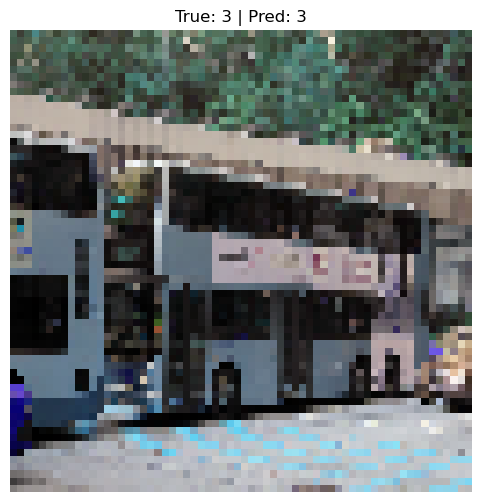

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Image 2: ✅ Correct! (51)


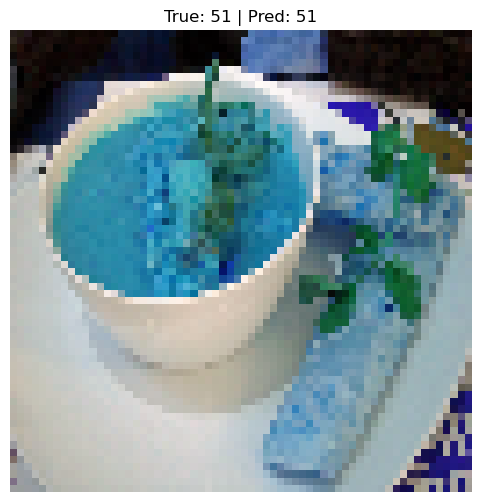

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Image 3: ❌ Incorrect. True: 32, Predicted: 21


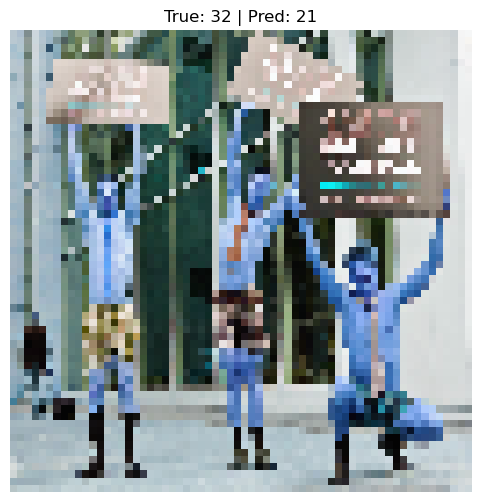

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Image 4: ✅ Correct! (1)


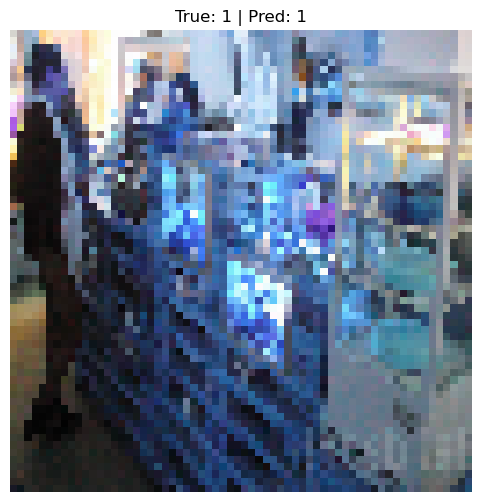

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Image 5: ✅ Correct! (1)


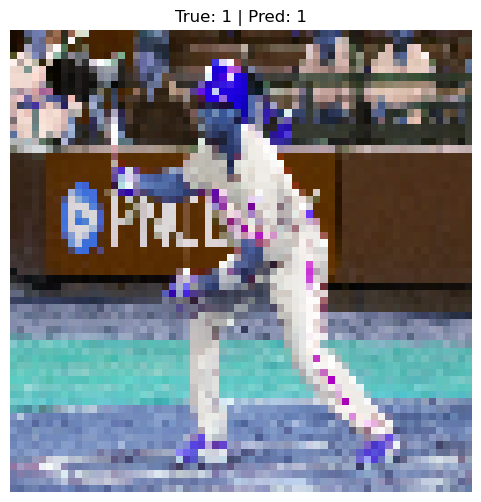

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Image 6: ✅ Correct! (1)


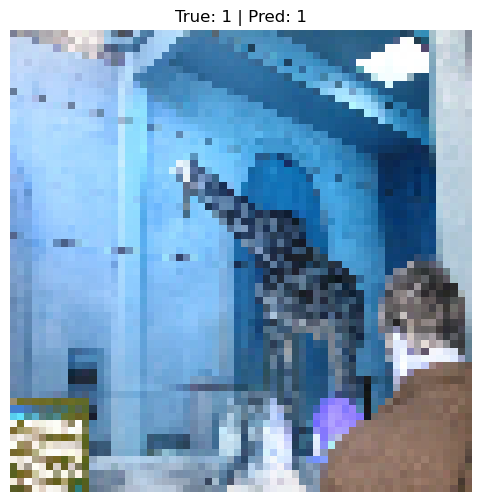

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Image 7: ❌ Incorrect. True: 37, Predicted: 3


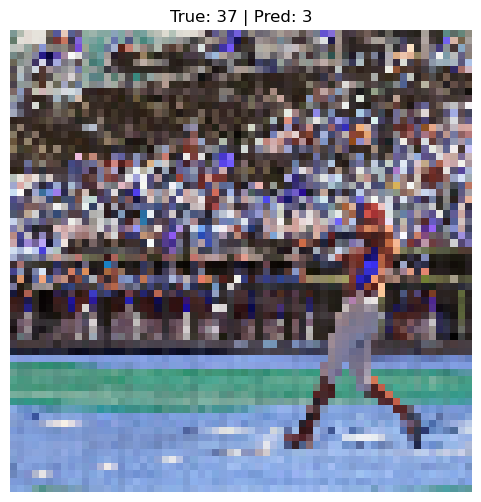

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Image 8: ✅ Correct! (65)


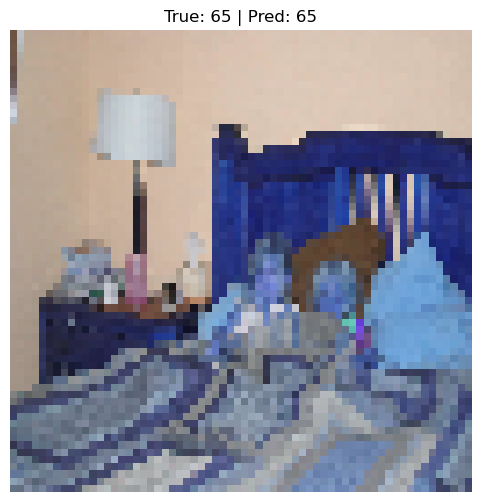

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Image 9: ✅ Correct! (1)


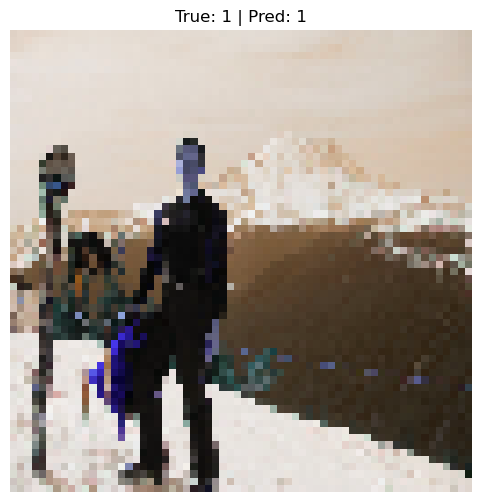

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Image 10: ✅ Correct! (1)


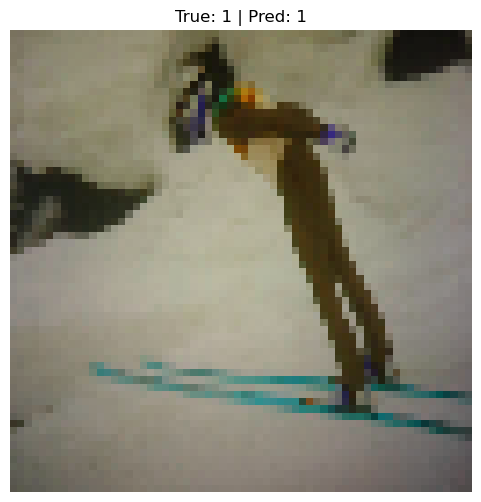

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Image 11: ✅ Correct! (1)


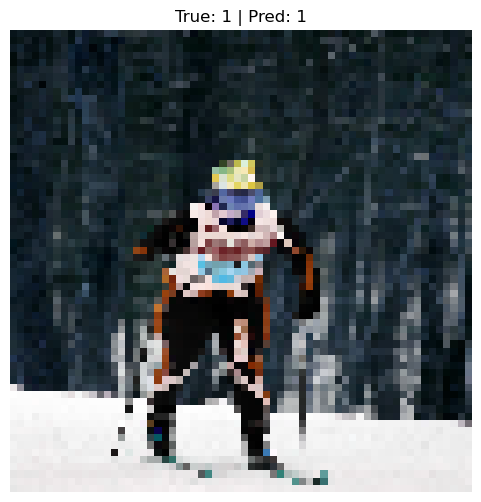

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Image 12: ✅ Correct! (62)


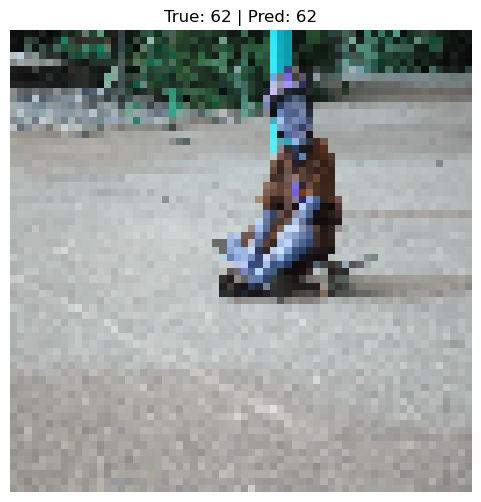

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Image 13: ✅ Correct! (3)


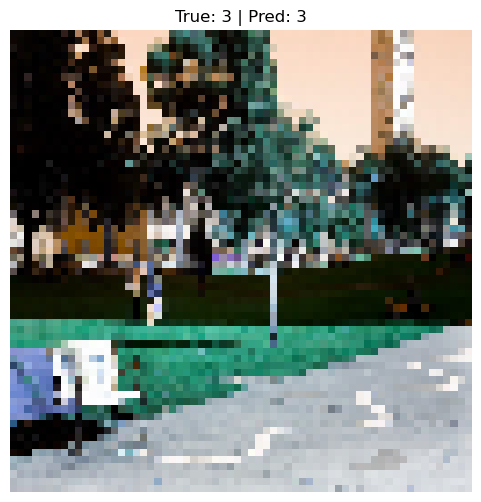

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Image 14: ✅ Correct! (5)


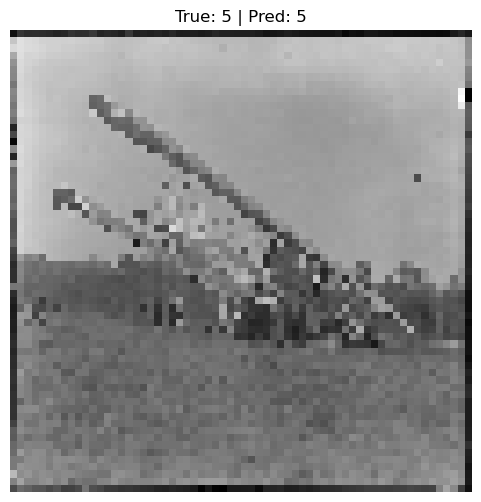

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Image 15: ✅ Correct! (37)


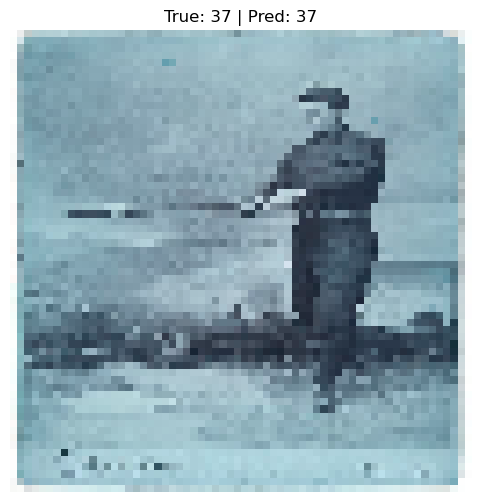

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Image 16: ✅ Correct! (7)


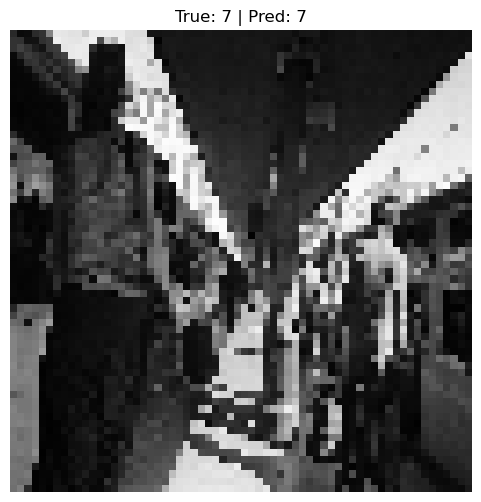

In [ ]:
# Number of random images to predict
num_predictions = 100
correct_predictions = 0  # Counter for correct predictions

# Loop through and display predictions for multiple random images
for i in range(num_predictions):
    # Pick a random image from the dataset
    random_idx = random.randint(0, len(X) - 1)
    sample_img = X[random_idx]

    # True label (assuming one-hot encoded labels `y_one_hot`)
    true_label = np.argmax(y_one_hot[random_idx])  

    # Predict the class of the sample image
    prediction = cnn_model.predict(np.expand_dims(sample_img, axis=0))
    predicted_class = np.argmax(prediction)

    # Decode labels to human-readable format
    true_label_decoded = label_encoder.inverse_transform([true_label])[0]
    predicted_label_decoded = label_encoder.inverse_transform([predicted_class])[0]

    # Display image with prediction and true label
    plt.figure(figsize=(6, 6))
    plt.imshow(sample_img)
    plt.axis("off")
    plt.title(f"True: {true_label_decoded} | Pred: {predicted_label_decoded}")

    # Check if prediction is correct
    if predicted_class == true_label:
        correct_predictions += 1
        print(f"Image {i+1}: ✅ Correct! ({predicted_label_decoded})")
    else:
        print(f"Image {i+1}: ❌ Incorrect. True: {true_label_decoded}, Predicted: {predicted_label_decoded}")

    plt.show()

In [25]:
# Calculate and display accuracy
accuracy = (correct_predictions / num_predictions) * 100
print(f"\nTotal Predictions: {num_predictions}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Prediction Accuracy: {accuracy:.2f}%")


Total Predictions: 50
Correct Predictions: 44
Prediction Accuracy: 88.00%
